In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import requests
import base64
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from scipy import signal
from scipy.io import wavfile
from torchsummary import summary
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score
from torchsampler import ImbalancedDatasetSampler
import shutil
from math import ceil, floor


Wav to spectrogram

nperseg: 448 noverlap: 181
File: 4666.wav, Spectrogram shape: (224, 224)


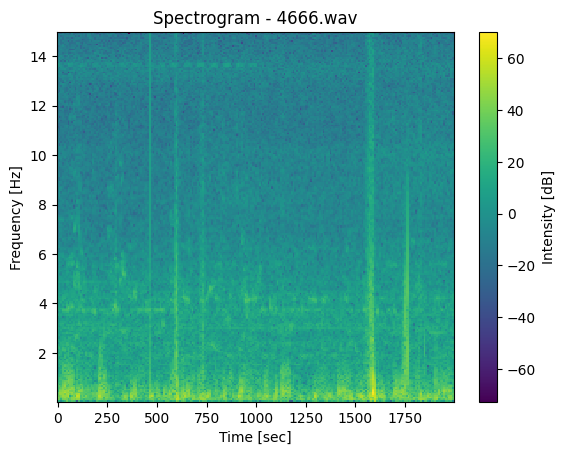

(7809, 1, 224, 224)


In [3]:
# Specify the folder path
#folder_path = '/content/drive/MyDrive/Colab_Notebooks/Project_Datasets/Train_Datasets'
folder_path = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'

# Get a list of all files in the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]



# List to store all log_spectrograms
all_spectrograms = []

def calculate_noverlap():
  steth_sample_rate = 4000
  duration = 15
  total_samples = steth_sample_rate * duration
  num_freq_bins = 224
  num_time_steps = 224

  nperseg = 2 * num_freq_bins  # (Nyquist limit)

  # num_time_steps = (total samples - noverlap) / (nperseg - noverlap)
  # t = s - o / p - o
  # tp - to = s - o
  # o = (tp - s) / (t - 1)

  noverlap = round((num_time_steps * nperseg - total_samples) / (num_time_steps - 1))
  return int(nperseg), int(noverlap)

nperseg, noverlap = calculate_noverlap()
print("nperseg:", nperseg, "noverlap:", noverlap)

def plot_spectrogram(nperseg, noverlap):
    # Iterate through each .wav file in the folder
    for wav_file in file_list:
        # Construct the full path to the .wav file
        wav_file_path = os.path.join(folder_path, wav_file)

        # Read the WAV file
        sample_rate, samples = wavfile.read(wav_file_path)

        # Compute the spectrogram
        frequencies, times, spectrogram = signal.spectrogram(samples, fs=sample_rate, nperseg=nperseg, noverlap=noverlap)

        # Apply logarithmic transformation
        log_spectrogram = resize(10 * np.log10(spectrogram+1e-10),(224,224))

        # Store the log_spectrogram in the list
        all_spectrograms.append(log_spectrogram)

    # Print the shape of the first spectrogram
    print(f"File: {file_list[0]}, Spectrogram shape: {all_spectrograms[0].shape}")

    # Ensure X has shape (225, 224) and Y has shape (224, 225)
    X, Y = np.meshgrid(times[:225], frequencies[:224], indexing='ij')

    #print(f"Original Spectrogram shape: {spectrogram.shape}")
    #print(f"Resized Spectrogram shape: {all_spectrograms[0].shape}")
    #print(f"X shape: {X.shape}")
    #print(f"Y shape: {Y.shape}")
    

    # Plot the first spectrogram
    plt.pcolormesh(Y, X, all_spectrograms[0], shading='auto')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(f'Spectrogram - {file_list[0]}')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

# Plot the spectrogram with calculated nperseg and noverlap
plot_spectrogram(nperseg, noverlap)

all_resized_spectrograms = np.reshape(np.array(all_spectrograms), newshape=(7809,1,224,224))

print(all_resized_spectrograms.shape)

Converting to a binary encoded matrix based on .npy files in train2

In [4]:
# Specify the folder path for .npy files
folder_path_npy = '/Users/aishwaryakrishnan/Documents/GitHub/AME508_finalproject/train2'

# Get a list of all .npy files in the folder
npy_file_list = [f for f in os.listdir(folder_path_npy) if f.endswith('.npy')]

# List to store the binary-encoded matrices
binary_encoded_matrices = []

# Iterate through each .npy file
for npy_file in npy_file_list:
    # Construct the full path to the .npy file
    npy_file_path = os.path.join(folder_path_npy, npy_file)

    # Load the .npy file
    label_array = np.load(npy_file_path)

    # Check the presence of wheeze, stridor, and rhonchi
    wheeze_present = label_array[0] == 1
    stridor_present = label_array[1] == 1
    rhonchi_present = label_array[2] == 1

    # Create a binary-encoded vector
    if wheeze_present==0 and stridor_present==0 and rhonchi_present==0:
        binary_code = 0
    else: 
        binary_code = 1
    #binary_encoded_vector = [int(wheeze_present), int(stridor_present), int(rhonchi_present)]

    # Append the vector to the list
    binary_encoded_matrices.append(binary_code)

# Convert the list to a NumPy array and reshape
binary_encoded_matrix = np.array(binary_encoded_matrices).reshape(-1, 1)

# Print the resulting binary-encoded matrix
print(binary_encoded_matrix.shape)


(7809, 1)


CustomDataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, samples, labels):
        """
        Initialize the CustomDataset with paired samples.

        Args:
            samples (list of tuples): A list of (x, y) pairs representing the dataset samples.
        """
        self.samples = torch.Tensor(samples).to(torch.float32)
        self.labels = torch.Tensor(labels).to(torch.float32)

    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns the sample pairs corresponding to the given list of indices.

        Args:
            indices (list): A list of indices to retrieve samples for.

        Returns:
            list: A list of (x, y) pairs corresponding to the specified indices.
        """
        selected_sample = self.samples[idx]
        selected_label = self.labels[idx]
        return selected_sample , selected_label
    
    def get_labels(self):
        """
        Returns the labels of the dataset.
        """
        return self.labels

In [14]:
batch_size = 32
train_dataset = CustomDataset(all_resized_spectrograms,binary_encoded_matrix)



trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size , shuffle=True)#, sampler=train_sampler)



In [15]:
class VGG16(nn.Module):
    def __init__(self, verbose=False):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5
        self.fc3 = nn.Linear(4096, 1)

        self.verbose = verbose

    def forward(self, x):
        if self.verbose:
            print(f"Input shape: {x.size()}")

        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        if self.verbose:
            print(f"After Layer 1: {x.size()}")

        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        if self.verbose:
            print(f"After Layer 2: {x.size()}")

        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool3(x)
        if self.verbose:
            print(f"After Layer 3: {x.size()}")

        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool4(x)
        if self.verbose:
            print(f"After Layer 4: {x.size()}")

        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool5(x)
        if self.verbose:
            print(f"After Layer 5 {x.size()}")

        x = torch.flatten(x,1)
        #x = torch.unsqueeze(1,x)
        if self.verbose:
            print(f"Flattened: {x.size()}")

        x = F.relu(self.fc1(x))
        if self.verbose:
            print(f"After first Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = F.relu(self.fc2(x))
        if self.verbose:
            print(f"After Secound Fully connected layer: {x.size()}")

        x = self.dropout(x)  # Apply dropout
        if self.verbose:
            print(f"After dropout: {x.size()}")

        x = self.fc3(x)
        x = torch.sigmoid(x)

        
        
        if self.verbose:
            print(f"Output shape: {x.size()}")

        return x

Check for GPU

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


Testing CNN shape

In [16]:
print("Intermediate shapes for VGG16")
model = VGG16(verbose=True)
output = model(torch.ones(size=(1,1,224,224)))
# More infor on VGG16 (https://builtin.com/machine-learning/vgg16)

Intermediate shapes for VGG16
Input shape: torch.Size([1, 1, 224, 224])
After Layer 1: torch.Size([1, 64, 112, 112])
After Layer 2: torch.Size([1, 128, 56, 56])
After Layer 3: torch.Size([1, 256, 28, 28])
After Layer 4: torch.Size([1, 512, 14, 14])
After Layer 5 torch.Size([1, 512, 7, 7])
Flattened: torch.Size([1, 25088])
After first Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
After Secound Fully connected layer: torch.Size([1, 4096])
After dropout: torch.Size([1, 4096])
Output shape: torch.Size([1, 1])


Train Loopw ith BCE_Loss

In [24]:
def train_loop_bce(model, criterion, optimizer, n_epoch, n_batches, print_every):
    
    loss_hist = np.zeros(n_epoch * n_batches)
    precision_hist = np.zeros(n_epoch * n_batches)
    recall_hist = np.zeros(n_epoch * n_batches)
    f1_hist = np.zeros(n_epoch * n_batches)

    it = 0
    iter = 0
    for epoch in range(n_epoch):
    
        all_predictions = []
        all_labels = []

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Store predictions and labels for evaluation
            predictions = (outputs > 0.5).float()  # Convert to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Print statistics
            loss_hist[iter] = loss.item()

            iter+=1
            #print(iter)

            if (i + 1) % print_every == 0:
                print('minibatch = {}/{}, loss = {}'.format(i + 1, n_batches, loss.item()))
            


        # Calculate precision, recall, and F1 score
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        precision = precision_score(all_labels, all_predictions, average='binary')
        recall = recall_score(all_labels, all_predictions, average='binary')
        f1 = f1_score(all_labels, all_predictions, average='binary')

        precision_hist[it] = precision
        recall_hist[it] = recall
        f1_hist[it] = f1

        print('epoch = {}/{}, Precision = {}, Recall = {}, F1 score = {}'.format(epoch + 1, n_epoch, precision, recall, f1))
        
        it += 1

    print("Finished Training")
    return loss_hist, precision_hist, recall_hist, f1_hist
    

In [26]:
model = VGG16()#.to(device)
criterion = nn.BCELoss()#pos_weight=class_weights_tensor)
learning_rate = 0.001 
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
n_epoch   = 10
n_batches = len(trainloader)
print_every = 1

loss_bce, precision_bce, recall_bce, f1_bce = train_loop_bce(model,criterion,optimizer,n_epoch,n_batches,print_every)

minibatch = 1/245, loss = 0.6934952735900879
minibatch = 2/245, loss = 0.9896013736724854
minibatch = 3/245, loss = 0.7831258773803711
minibatch = 4/245, loss = 0.7466772198677063
minibatch = 5/245, loss = 0.6683405637741089
minibatch = 6/245, loss = 9.878283500671387
minibatch = 7/245, loss = 0.6923003792762756
minibatch = 8/245, loss = 0.6940879821777344
minibatch = 9/245, loss = 0.6951857805252075
minibatch = 10/245, loss = 0.6930027008056641
minibatch = 11/245, loss = 0.6949132084846497
minibatch = 12/245, loss = 0.6948862075805664
minibatch = 13/245, loss = 0.6928284764289856
minibatch = 14/245, loss = 0.6911544799804688
minibatch = 15/245, loss = 0.679841935634613
minibatch = 16/245, loss = 0.6776601672172546
minibatch = 17/245, loss = 0.6505931615829468
minibatch = 18/245, loss = 0.7945888638496399
minibatch = 19/245, loss = 0.6191996335983276
minibatch = 20/245, loss = 0.6597217321395874
minibatch = 21/245, loss = 0.6964865326881409
minibatch = 22/245, loss = 0.6732889413833618

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.6710652709007263
minibatch = 2/245, loss = 0.6196171045303345
minibatch = 3/245, loss = 0.6028881669044495
minibatch = 4/245, loss = 0.7061076164245605
minibatch = 5/245, loss = 0.6284416913986206
minibatch = 6/245, loss = 0.6920823454856873
minibatch = 7/245, loss = 0.6825964450836182
minibatch = 8/245, loss = 0.6241808533668518
minibatch = 9/245, loss = 0.6417301893234253
minibatch = 10/245, loss = 0.6172387003898621
minibatch = 11/245, loss = 0.646302342414856
minibatch = 12/245, loss = 0.6979374885559082
minibatch = 13/245, loss = 0.628919243812561
minibatch = 14/245, loss = 0.6840174794197083
minibatch = 15/245, loss = 0.7627547979354858
minibatch = 16/245, loss = 0.698143482208252
minibatch = 17/245, loss = 0.6986991167068481
minibatch = 18/245, loss = 0.6288825869560242
minibatch = 19/245, loss = 0.6726442575454712
minibatch = 20/245, loss = 0.6776207685470581
minibatch = 21/245, loss = 0.6348317861557007
minibatch = 22/245, loss = 0.690904974937439
m

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.7137269973754883
minibatch = 2/245, loss = 0.6514437198638916
minibatch = 3/245, loss = 0.6233488321304321
minibatch = 4/245, loss = 0.6437469720840454
minibatch = 5/245, loss = 0.6497693061828613
minibatch = 6/245, loss = 0.6478079557418823
minibatch = 7/245, loss = 0.6987771987915039
minibatch = 8/245, loss = 0.6610337495803833
minibatch = 9/245, loss = 0.6623533964157104
minibatch = 10/245, loss = 0.6875927448272705
minibatch = 11/245, loss = 0.6477469801902771
minibatch = 12/245, loss = 0.7002383470535278
minibatch = 13/245, loss = 0.6677784323692322
minibatch = 14/245, loss = 0.6132515072822571
minibatch = 15/245, loss = 0.6919813752174377
minibatch = 16/245, loss = 0.6306930780410767
minibatch = 17/245, loss = 0.6371835470199585
minibatch = 18/245, loss = 0.6831433773040771
minibatch = 19/245, loss = 0.6585081219673157
minibatch = 20/245, loss = 0.6477041840553284
minibatch = 21/245, loss = 0.6650320291519165
minibatch = 22/245, loss = 0.65840327739715

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.6641764640808105
minibatch = 2/245, loss = 0.6604071259498596
minibatch = 3/245, loss = 0.6195172667503357
minibatch = 4/245, loss = 0.7032074928283691
minibatch = 5/245, loss = 0.6286771297454834
minibatch = 6/245, loss = 0.6518538594245911
minibatch = 7/245, loss = 0.712774932384491
minibatch = 8/245, loss = 0.6543548703193665
minibatch = 9/245, loss = 0.7058632373809814
minibatch = 10/245, loss = 0.6645328998565674
minibatch = 11/245, loss = 0.6515953540802002
minibatch = 12/245, loss = 0.632356584072113
minibatch = 13/245, loss = 0.6760262250900269
minibatch = 14/245, loss = 0.6778684854507446
minibatch = 15/245, loss = 0.6321094632148743
minibatch = 16/245, loss = 0.6571451425552368
minibatch = 17/245, loss = 0.6677741408348083
minibatch = 18/245, loss = 0.6396061778068542
minibatch = 19/245, loss = 0.705623984336853
minibatch = 20/245, loss = 0.5822813510894775
minibatch = 21/245, loss = 0.6722724437713623
minibatch = 22/245, loss = 0.6904210448265076


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.6981579661369324
minibatch = 2/245, loss = 0.5704144239425659
minibatch = 3/245, loss = 0.5898361802101135
minibatch = 4/245, loss = 0.5853416919708252
minibatch = 5/245, loss = 0.7570656538009644
minibatch = 6/245, loss = 0.5975912809371948
minibatch = 7/245, loss = 0.6902769207954407
minibatch = 8/245, loss = 0.6436498165130615
minibatch = 9/245, loss = 0.74213707447052
minibatch = 10/245, loss = 0.7011135816574097
minibatch = 11/245, loss = 0.5354627966880798
minibatch = 12/245, loss = 0.6615998148918152
minibatch = 13/245, loss = 0.6783179640769958
minibatch = 14/245, loss = 0.6622644066810608
minibatch = 15/245, loss = 0.656879723072052
minibatch = 16/245, loss = 0.6975879073143005
minibatch = 17/245, loss = 0.6970175504684448
minibatch = 18/245, loss = 0.6888828873634338
minibatch = 19/245, loss = 0.652832567691803
minibatch = 20/245, loss = 0.6529774069786072
minibatch = 21/245, loss = 0.6881102919578552
minibatch = 22/245, loss = 0.6344918608665466
m

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.6429044008255005
minibatch = 2/245, loss = 0.6151577234268188
minibatch = 3/245, loss = 0.6770845651626587
minibatch = 4/245, loss = 0.6857731342315674
minibatch = 5/245, loss = 0.6898707747459412
minibatch = 6/245, loss = 0.6764465570449829
minibatch = 7/245, loss = 0.6074349880218506
minibatch = 8/245, loss = 0.6868747472763062
minibatch = 9/245, loss = 0.6609784960746765
minibatch = 10/245, loss = 0.6515586972236633
minibatch = 11/245, loss = 0.6422179341316223
minibatch = 12/245, loss = 0.6332581043243408
minibatch = 13/245, loss = 0.6467822790145874
minibatch = 14/245, loss = 0.5891626477241516
minibatch = 15/245, loss = 0.682701051235199
minibatch = 16/245, loss = 0.6184771656990051
minibatch = 17/245, loss = 0.6338385343551636
minibatch = 18/245, loss = 0.608015775680542
minibatch = 19/245, loss = 0.6664906740188599
minibatch = 20/245, loss = 0.7680894732475281
minibatch = 21/245, loss = 0.7300797700881958
minibatch = 22/245, loss = 0.6231234669685364

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.6750524044036865
minibatch = 2/245, loss = 0.6831902861595154
minibatch = 3/245, loss = 0.6168434023857117
minibatch = 4/245, loss = 0.7615084648132324
minibatch = 5/245, loss = 0.6082144975662231
minibatch = 6/245, loss = 0.6406034231185913
minibatch = 7/245, loss = 0.745250403881073
minibatch = 8/245, loss = 0.6763783693313599
minibatch = 9/245, loss = 0.6521041989326477
minibatch = 10/245, loss = 0.6266976594924927
minibatch = 11/245, loss = 0.7084569931030273
minibatch = 12/245, loss = 0.6778100728988647
minibatch = 13/245, loss = 0.6485600471496582
minibatch = 14/245, loss = 0.637459933757782
minibatch = 15/245, loss = 0.6483028531074524
minibatch = 16/245, loss = 0.6950177550315857
minibatch = 17/245, loss = 0.6994337439537048
minibatch = 18/245, loss = 0.677864134311676
minibatch = 19/245, loss = 0.6392397284507751
minibatch = 20/245, loss = 0.6390112638473511
minibatch = 21/245, loss = 0.6643107533454895
minibatch = 22/245, loss = 0.6753899455070496


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


minibatch = 1/245, loss = 0.7278847694396973
minibatch = 2/245, loss = 0.6426872611045837
minibatch = 3/245, loss = 0.6705392599105835
minibatch = 4/245, loss = 0.6447125673294067
minibatch = 5/245, loss = 0.6614412069320679
minibatch = 6/245, loss = 0.6762354373931885
minibatch = 7/245, loss = 0.6482201218605042
minibatch = 8/245, loss = 0.5802947282791138
minibatch = 9/245, loss = 0.6970116496086121
minibatch = 10/245, loss = 0.7404432892799377
minibatch = 11/245, loss = 0.6110942363739014
minibatch = 12/245, loss = 0.6812783479690552
minibatch = 13/245, loss = 0.6668294072151184
minibatch = 14/245, loss = 0.6524059772491455
minibatch = 15/245, loss = 0.7333936095237732
minibatch = 16/245, loss = 0.7386919260025024
minibatch = 17/245, loss = 0.6915299892425537
minibatch = 18/245, loss = 0.6382625102996826
minibatch = 19/245, loss = 0.6590036153793335
minibatch = 20/245, loss = 0.6918678879737854
minibatch = 21/245, loss = 0.6430496573448181
minibatch = 22/245, loss = 0.63695091009140

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'\naxs[1].plot(acc_, label = "TrainDatasets")\naxs[1].set_ylabel(\'Accuracy [%]\')\naxs[1].set_xlabel(\'Iterations\')\naxs[1].legend()\n'

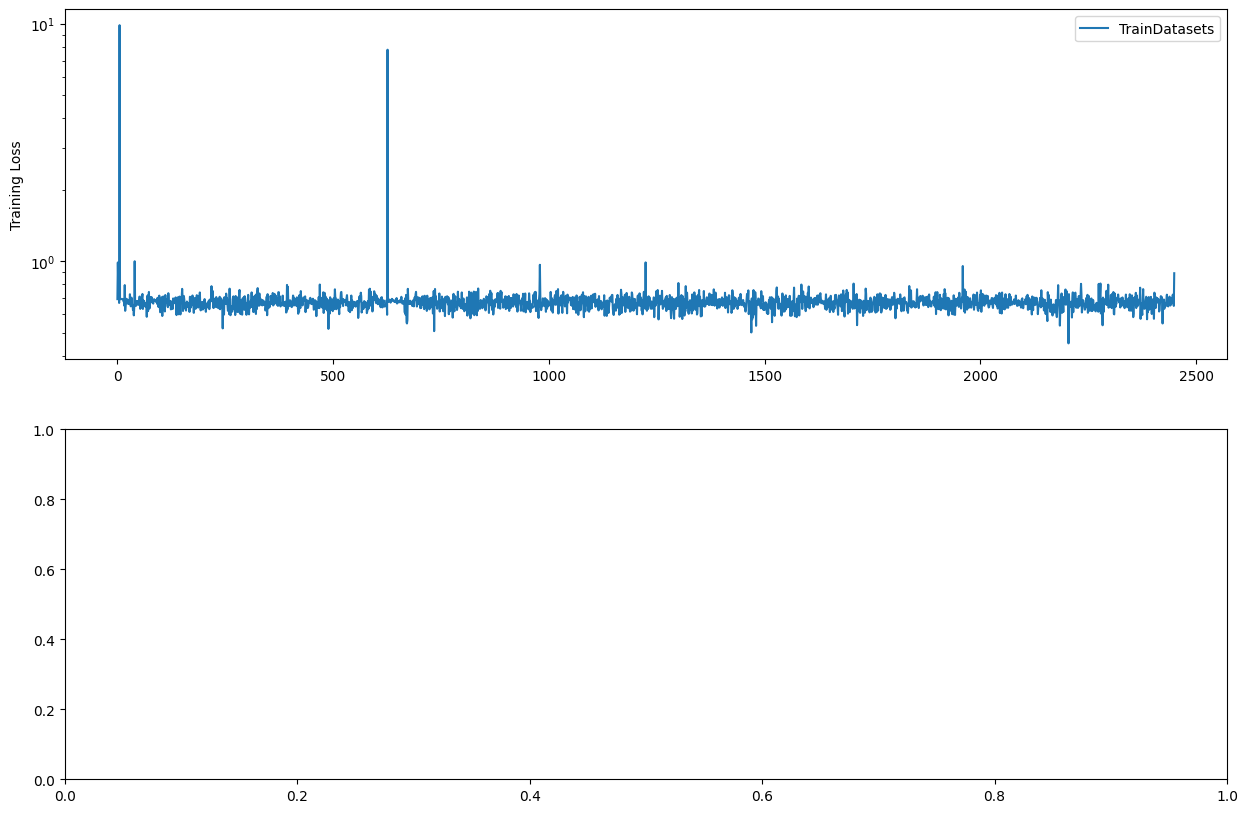

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(loss_bce, label = "TrainDatasets")
axs[0].set_yscale('log')
axs[0].set_ylabel('Training Loss')
axs[0].legend()

'''
axs[1].plot(acc_, label = "TrainDatasets")
axs[1].set_ylabel('Accuracy [%]')
axs[1].set_xlabel('Iterations')
axs[1].legend()
'''